In [1]:
from scipy.io import loadmat
import numpy as np
from matplotlib.image import imread
import random
import matplotlib.pyplot as plt

In [2]:
data = loadmat('data/compEx1data.mat')
K = data['K']
x = data['x']
x1s = x[0][0]
x2s = x[0][1]

In [3]:
def normalize_points(points, K):
    K_inv = np.linalg.inv(K)
    normalized_points = K_inv @ points
    return normalized_points

def enforce_essential(E_approx):
    U, S, Vt = np.linalg.svd(E_approx)
    S = np.array([1,1,0])
    E = U @ np.diag(S) @ Vt
    return E

def convert_E_to_F(E, K1, K2):
    K1_inv = np.linalg.inv(K1)
    K2_inv = np.linalg.inv(K1)
    F = K2_inv.T @ E @ K1_inv
    return F

def estimate_E_DLT(x1s, x2s,K, norm=True):
    if norm == True:
        x1n = normalize_points(x1s,K)
        x2n = normalize_points(x2s,K)
    else:
        x1n = x1s
        x2n = x2s
    
    M = []
    for i in range(x1n.shape[1]):
        x1, y1, _ = x1n[:, i]
        x2, y2, _ = x2n[:, i]
        M.append([x2 * x1, x2 * y1, x2, y2 * x1, y2 * y1, y2, x1, y1, 1])
    M = np.array(M)

    U, S, Vt = np.linalg.svd(M)
    v = Vt[-1]
    E_approx = v.reshape(3, 3)

    min_singular_value = S[-1]
    residual = np.linalg.norm(M @ v)
    
    E = enforce_essential(E_approx)
    
    return E

def compute_point_to_line_distances(l, x):
    l1 = l[0,:]
    l2 = l[1,:]
    l3 = l[2,:]
    x1 = x[0,:]
    x2 = x[1,:]
    
    numerator = np.abs(l1*x1 + l2*x2 + l3)
    denominator = np.sqrt(l1**2 + l2**2)
    distances = numerator / denominator
    
    return distances

def compute_rms_error(F, x1s, x2s):
    l1 = F.T @ x2s
    l2 = F @ x1s
    d1 = compute_point_to_line_distances(l1,x1s)
    d2 = compute_point_to_line_distances(l2,x2s)
    rms_error = np.sqrt((np.sum(d1**2) + np.sum(d2**2)) / (2 * x1s.shape[1]))
    return rms_error


def estimate_E_robust(x1, x2, K, eps, max_iterations=1000):
    x1n = normalize_points(x1, K)
    x2n = normalize_points(x2, K)

    best_inliers = None
    best_E = None
    max_inliers = 0

    for _ in range(max_iterations):
        indices = np.random.choice(x1n.shape[1], 8, replace=False)
        x1_sample = x1n[:, indices]
        x2_sample = x2n[:, indices]

        E_candidate = estimate_E_DLT(x1_sample, x2_sample, K, norm=False)
        
        l1 = E_candidate.T @ x2n
        errors1 = compute_point_to_line_distances(l1,x1n)
        
        l2 = E_candidate @ x1n
        errors2 = compute_point_to_line_distances(l2,x2n)

        errors = (errors1**2 + errors2**2) / 2
        
        inliers = errors < (eps**2)
        num_inliers = np.sum(inliers)
       
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_inliers = inliers
            best_E = E_candidate

    print(f"Number of inliers: {max_inliers}")
    return best_E, best_inliers


def plot_epipolar_lines(image, points, epipolar_lines, path):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[0, :], points[1, :], c='red', marker='o', s=10)

    for i in range(epipolar_lines.shape[1]):
        a, b, c = epipolar_lines[:, i]
        x = np.linspace(0, image.shape[1], 100)
        y = -(a * x + c) / b
        plt.plot(x, y)

    plt.xlim(0,1936)
    plt.ylim(1296,0)
    plt.savefig(path)
    plt.show()

RMS Error: 155.9583229021138


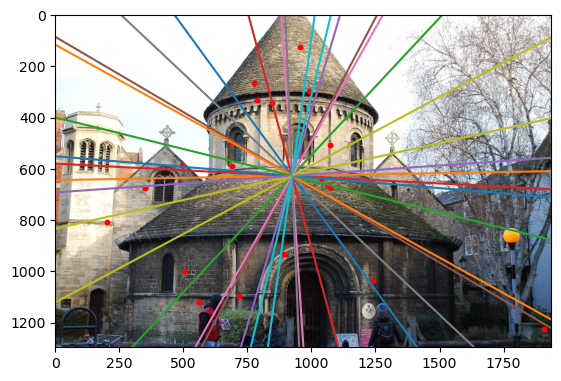

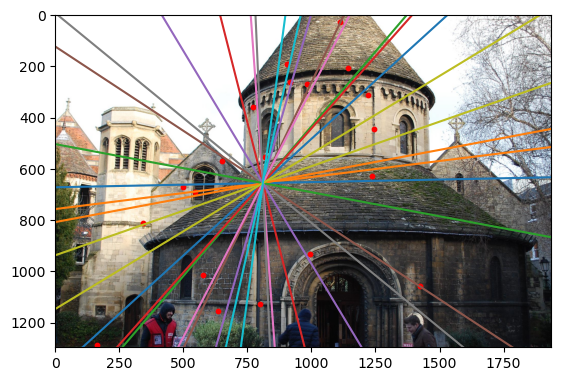

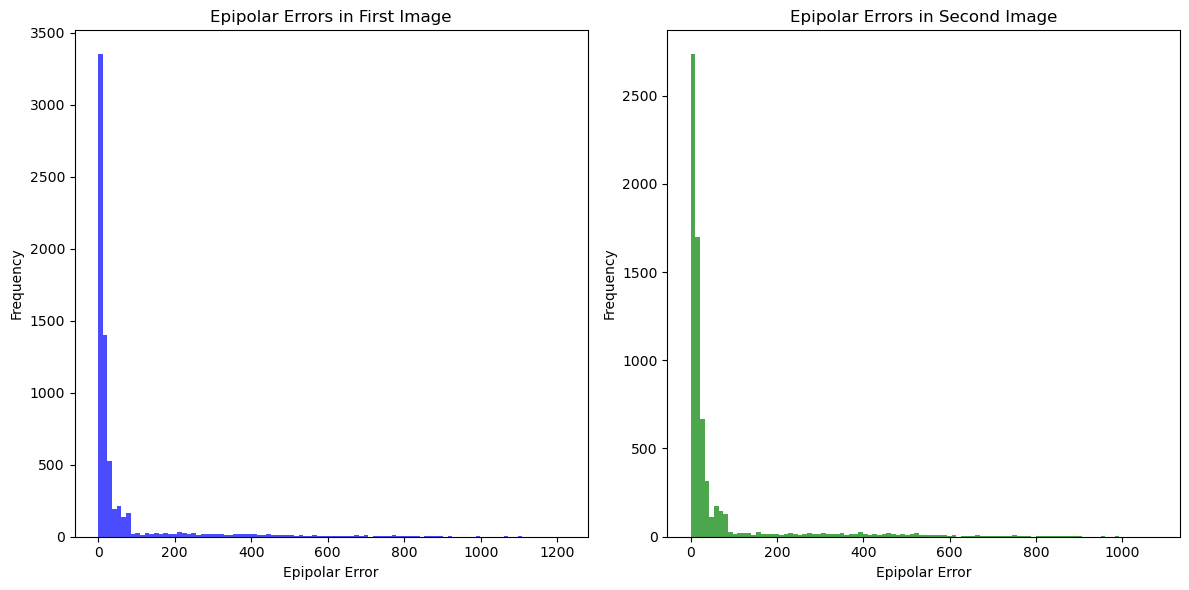

In [4]:
E = estimate_E_DLT(x1s, x2s, K)

F = convert_E_to_F(E, K, K)

rms_error = compute_rms_error(F, x1s, x2s)
print(f"RMS Error: {rms_error}")

random_indices = np.random.choice(x1s.shape[1], 20, replace=False)

x1_points = x1s[:, random_indices]
x2_points = x2s[:, random_indices]

l1 = F.T @ x2_points
l2 = F @  x1_points

image1 = imread('data/round_church1.jpg')
plot_epipolar_lines(image1, x1_points, l2, "figs/compEx1/epipolar_lines_image1.png")

image2 = imread('data/round_church2.jpg')
plot_epipolar_lines(image2, x2_points, l1, "figs/compEx1/epipolar_lines_image2.png")

l1_hist = F.T @ x2s
l2_hist = F @ x1s
d1 = compute_point_to_line_distances(l1_hist,x1s)
d2 = compute_point_to_line_distances(l2_hist,x2s)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
axes[0].hist(d1, bins=100, alpha=0.7, color='blue')
axes[0].set_title('Epipolar Errors in First Image')
axes[0].set_xlabel('Epipolar Error')
axes[0].set_ylabel('Frequency')

axes[1].hist(d2, bins=100, alpha=0.7, color='green')
axes[1].set_title('Epipolar Errors in Second Image')
axes[1].set_xlabel('Epipolar Error')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig("figs/compEx1/epipolar_error_histogram_ex1.png")
plt.show()



Number of inliers: 5816
RMS Error: 0.425534290586884


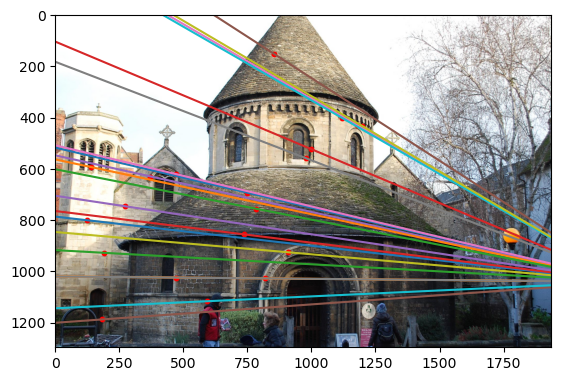

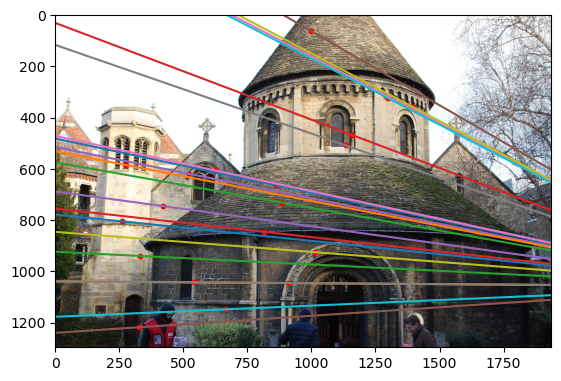

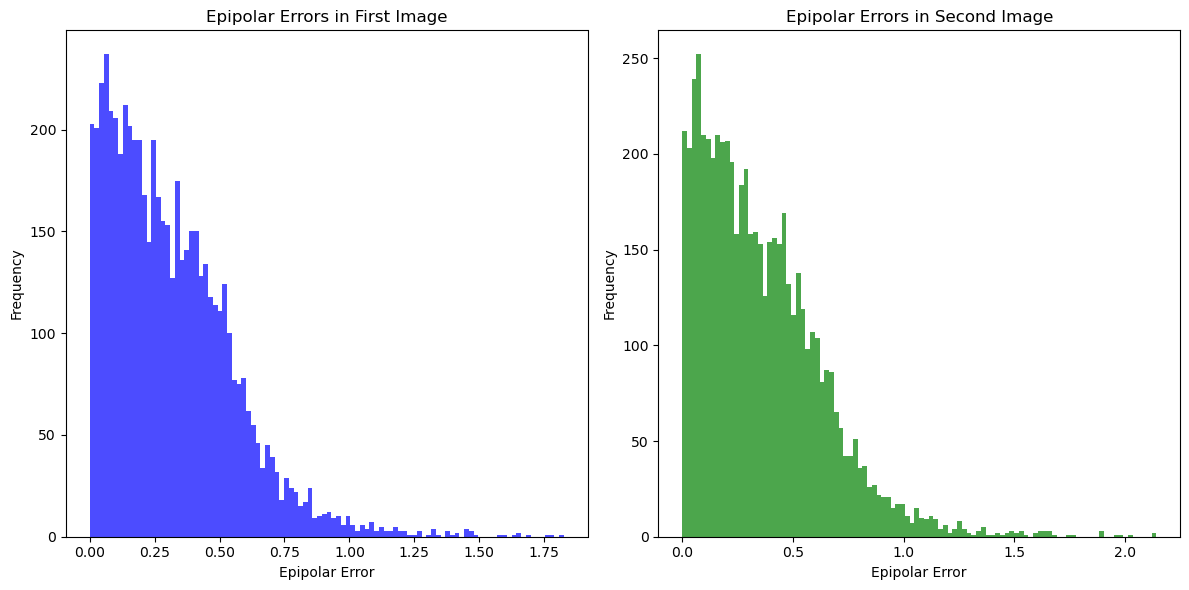

In [5]:
inlier_threshold_px = 2
eps = inlier_threshold_px * 2 / (K[0, 0] + K[1, 1])

best_E, best_inliers = estimate_E_robust(x1s, x2s, K, eps)

best_F = convert_E_to_F(best_E, K, K)

x1_inliers = x1s[:, best_inliers]
x2_inliers = x2s[:, best_inliers]

rms_error = compute_rms_error(best_F, x1_inliers, x2_inliers)
print(f"RMS Error: {rms_error}")

random_inlier_indices= np.random.choice(x1_inliers.shape[1], 20, replace=False)

l1 = best_F.T @ x2_inliers[:, random_inlier_indices]
l2 = best_F @  x1_inliers[:, random_inlier_indices]

plot_epipolar_lines(image1, x1_inliers[:, random_inlier_indices], l1, "figs/compEx1/epipolar_lines_inliers_image1.png")
plot_epipolar_lines(image2, x2_inliers[:, random_inlier_indices], l2, "figs/compEx1/epipolar_lines_inliers_image2.png")


l1_hist = best_F.T @ x2_inliers
l2_hist = best_F @ x1_inliers
d1 = compute_point_to_line_distances(l1_hist, x1_inliers)
d2 = compute_point_to_line_distances(l2_hist, x2_inliers)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(d1, bins=100, alpha=0.7, color='blue')
axes[0].set_title('Epipolar Errors in First Image')
axes[0].set_xlabel('Epipolar Error')
axes[0].set_ylabel('Frequency')

axes[1].hist(d2, bins=100, alpha=0.7, color='green')
axes[1].set_title('Epipolar Errors in Second Image')
axes[1].set_xlabel('Epipolar Error')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig("figs/compEx1/epipolar_error_histogram_inliers_ex1.png")
plt.show()